In [1]:
import os
import sys
import numpy as np
import pandas as pd
from librosa import note_to_hz
from scipy.io import wavfile
from IPython.display import display, Audio
from matplotlib import pyplot

sys.path.append('../tuner')
from tuner_api_wrapper import *

In [2]:
WINDOW_SIZE = 512
OSAMP = 64
DO_HIGHPASS = True
DO_HILBERT_TRANSFORM = True

In [3]:
current_dir = str(Path().resolve())
audio_path = os.path.normpath(current_dir + '/../audio/humming_short.wav')
sample_rate, audio = wavfile.read(audio_path)

In [4]:
detected_freqs = tuner_pitch_detect(
    audio, 
    sample_rate,
    WINDOW_SIZE,
    OSAMP,
    DO_HIGHPASS,
    DO_HILBERT_TRANSFORM,
)

In [5]:
c_major = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
min_octave = -8
max_octave = 8
scale = []
for octave in range(min_octave, max_octave):
    for note in c_major:
        scale.append(note_to_hz(note + str(octave)))

In [6]:
corrected_freqs = tuner_pitch_snap(detected_freqs, scale)

In [7]:
shifted_audio = tuner_pitch_shift(
    audio,
    sample_rate,
    WINDOW_SIZE,
    OSAMP,
    detected_freqs,
    corrected_freqs,
)

Detected frequencies


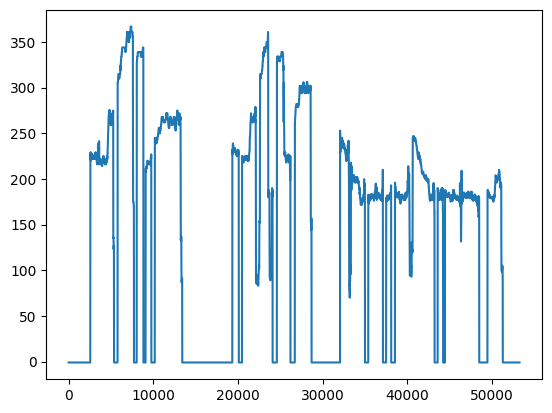

Corrected frequencies


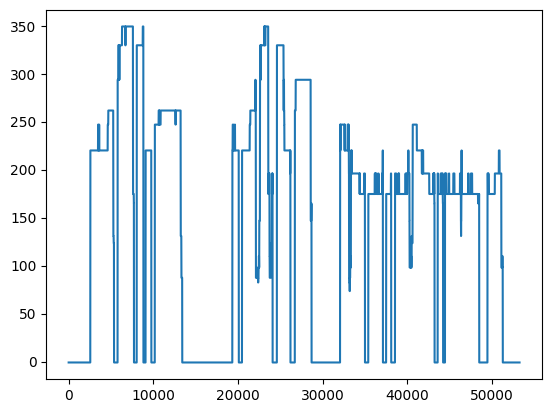

Original audio


Pitch shifted audio


In [8]:
print('Detected frequencies')
pyplot.plot(detected_freqs)
pyplot.show()
print('Corrected frequencies')
pyplot.plot(corrected_freqs)
pyplot.show()
print('Original audio')
display(Audio(audio, rate=sample_rate))
print('Pitch shifted audio')
display(Audio(shifted_audio, rate=sample_rate))